In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as inte
from astropy import units as u
from astropy import constants as const

In [51]:
#constants and units
H0 = 67.9 * u.km/u.s/u.Mpc
c = const.c
G = const.G.to(u.km**2 * u.Mpc /u.Msun/u.s**2)
chirpM = 26*u.Msun
rho_crit = (3/8/np.pi) * H0**2 /G # has dimensions of density (mass/volume)

fref = 25. /u.s
OmegaGW_limit = 4.8e-8
Rate = 53.2 /(u.Gpc**3 * u.year)
t_obs = 1.5 *u.year

m_min = 6.7 #* u.Msun
m_max = 41.9 #* u.Msun
gamma = -1.4

## Horizon Distance of a Euclidian Universe 

$$ r_{\text{hor}} = \frac{9\Omega_{\text{ref}} H_0^2 c^3}{8 \mathcal{R}} (f_{\text{ref}})^{-2/3} ( G \pi \mathcal{M})^{-5/3} $$ 

Where $\mathcal{R}$ is the rate density of events. Here we have assumed it to be the local merger rate $\mathcal{R}_0$. 

In [4]:
def r_hor(H0,c,G,Mchirp,Omega,fref,R):
    '''calculates the horizon distance assuming a euclidian static universe.
    Inputs must all have astropy units.'''
    Omegaf = Omega*np.power(fref,-2./3)
    GpiM53 = np.power(G*np.pi*Mchirp,-5./3)
    Hoc = H0**2 *(c**3)
    
    rhor = (9/(8 * R)) * Hoc * GpiM53 * Omegaf
    return rhor

In [5]:
r = r_hor(H0,c,G,chirpM,OmegaGW_limit,fref,Rate)
r.to(u.Gpc)

<Quantity 87.6129624038377 Gpc>

In [6]:
hubble_dist = c/H0
(r/hubble_dist).to(u.m/u.m)

<Quantity 19.84346166313644>

In [8]:
#chirp mass for two 30 solar mass BHs
m = 30 * u.Msun
M53 = m*m*(m+m)**(-1/3)
M53**(3/5)

<Quantity 26.1165169 solMass>

In [26]:
# if you want to integrate over observing time instead of the age of the U (this no longer makes sense)
def r_hor_tobs(H0,c,G,Mchirp,Omega,fref,R,tobs):
    '''calculates the horizon distance assuming a euclidian static universe.
    Inputs must all have astropy units.'''
    Omegaf = Omega*np.power(fref,-2./3)
    GpiM53 = np.power(G*np.pi*Mchirp,-5./3)
    Hoc = H0 *(c**3)
    N = R * tobs
    
    rhor = (9./(8 *N)) * Hoc * GpiM53 * Omegaf
    return rhor

In [21]:
r = r_hor_tobs(H0,c,G,chirpM,OmegaGW_limit,fref,Rate,t_obs)
r.to(u.Gpc)

<Quantity 841112156663.8446 Gpc>

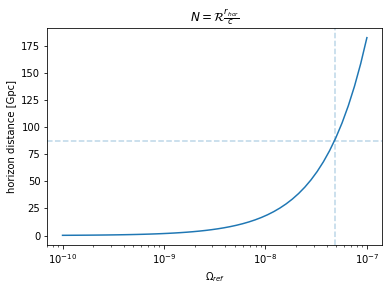

In [9]:
#plot them
possible_omegas = np.logspace(-10,-7)
# --- t= age of U ---#
plt.plot(possible_omegas,r_hor(H0,c,G,chirpM,possible_omegas,fref,Rate).to(u.Gpc))
plt.axvline(OmegaGW_limit,linestyle='--',alpha=0.3)
plt.axhline(87.6,linestyle='--',alpha=0.3)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\Omega_{ref}$')
plt.ylabel('horizon distance [Gpc]')
plt.title(r'$N = \mathcal{R}\frac{r_{hor}}{c}$')
plt.show()
# #--- t = t_obs ---#
# plt.plot(possible_omegas,r_hor_tobs(H0,c,G,chirpM,possible_omegas,fref,Rate,t_obs).to(u.Gpc))
# plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel(r'$\Omega_{ref}$')
# plt.ylabel('horizon distance [Gpc]')
# plt.title(r'$N = \mathcal{R}t_{obs}$')
# plt.show()

### Adding in a mass distribution

$$\rho_c c^2 \Omega_{GW}(f) =  r_{hor} \frac{H_0}{c} \frac{(f G \pi)^{2/3}}{3 (2)^{1/3}} \int d t \frac{\mathcal{R}_0 (2\gamma +1)}{m_{max}^{2\gamma +1} - m_{min}^{2\gamma +1}} [\frac{m_{max}^{2\gamma +8/3} - m_{min}^{2\gamma +8/3}}{(2\gamma +8/3)}] $$

In [14]:
#this assumes equal masses and a power law for each component mass
def r_hor_marg_Mchirp(H0,c,G,Omega,fref,R0):
    '''calculates the horizon distance assuming a euclidian static universe.
    Inputs must all have astropy units.'''
    Omegaf = Omega*np.power(fref,-2./3)
    Gpi53 = np.power(np.pi,-5./3)
    Hoc = H0**2 * (c**3)
    
    prefac = R0/(2**(1./3))
    power = (2 * gamma + 1)
    norm = power /(np.power(m_max,power) - np.power(m_min,power))    
    RofM = norm * prefac \
    * (np.power(m_max,power)*np.power(m_max*G,5./3)-np.power(m_min,power)*np.power(m_min*G,5./3)) \
    / (power+5./3)
    #(you have to do some finegling to get the 5/3 thing to cancel units with the mass in G properly but this does the trick^)
    
    rhor = (9./(8 *RofM)) * Hoc * Gpi53 * Omegaf
    return rhor

In [15]:
r_hor_marg_Mchirp(H0,c,G,OmegaGW_limit,fref,Rate).to(u.Gpc)

<Quantity 348.01806764493966 Gpc>

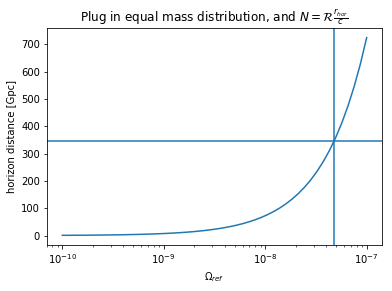

In [16]:
plt.plot(possible_omegas,r_hor_marg_Mchirp(H0,c,G,possible_omegas,fref,Rate).to(u.Gpc))
plt.axvline(OmegaGW_limit)
plt.axhline(348.0)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\Omega_{ref}$')
plt.ylabel('horizon distance [Gpc]')
plt.title(r'Plug in equal mass distribution, and $N = \mathcal{R}\frac{r_{hor}}{c}$')
plt.show()

## Putting Limits on FLRW parameters

$ \rho_c c^2 \Omega_{GW} (f) = \frac{(f \pi G)^{2/3}}{3} \mathcal{R_0} \int_0^{z_f} \frac{\mathrm{d}z}{(1+z)^{1/3} H(z)} \text{(massfac)(z-ev0)} $

where $ \text{massfac} = \int_0^\infty \text{d}\mathcal{M} \frac{\text{d}\mathcal{R}(\mathcal{M},z)}{\text{d}\mathcal{M}} \mathcal{M}^{5/3}$ accounts for the mass distribution of binaries and $ \text{z-evo} = \mathcal{C}(\alpha,\beta,z_p) \frac{(1+z)^{\alpha}}{1 + (\frac{1+z}{1+z_p})^{\alpha+\beta}} $ is the redshift evolution of the merger rate.

In [61]:
def equal_masses(R0,gamma,m_min,m_max):
    '''lets again assume the equal masses model that does not evolve in redshift 
    (eventually we will want to evolve it in redshift so that zf has an astrophysical rather that cosmological meaning)
    '''
    prefac = R0/(2**(1./3))
    power = (2 * gamma + 1)
    norm = power /(np.power(m_max,power) - np.power(m_min,power)) 
    massfac = norm * prefac \
    * (np.power(m_max,power)*np.power(m_max,5./3)-np.power(m_min,power)*np.power(m_min,5./3)) \
    / (power+5./3)
    return massfac

def int_over_z(z,Omega_m,Omega_Lam,Omega_r, zp=0,alpha=0,beta=0):
    ''' putting in values for zp, alpha, and beta gives the redshift evolution in Callister et al 2020'''
    Omega_k = 1 - (Omega_m + Omega_Lam + Omega_r)
    H_z = np.sqrt(Omega_Lam + Omega_r * (1 + z)**4. + Omega_m * (1 + z)**3. + Omega_k * (1 + z)**2. )
    
    z_evo = np.power(1+z,alpha)/(1+ np.power((1+z)/(1+zp),beta))
    C =  1 + np.power(1+zp,-1*(alpha+beta))
    
    integrand = z_evo * C / ((1+z)*H_z)
    return integrand

def OmegaGW(zf,Omega_m,fref,massdist=equal_masses,z_evo_params=[0,0,0]):
    fpiG = np.power(fref*np.pi*G,2./3)/3.
    rhoc2 = ( c**2 ) * ( H0**2 ) * 3 /( 8 * np.pi * G )
    massfac = massdist(gamma,m_min,m_max) * np.power(u.Msun,5./3)
    integral = inte.quad(int_over_z,0,zf,
                         args=(Omega_m, 1-Omega_m,0,z_evo_params[0],
                               z_evo_params[1],z_evo_params[2])
                        )[0]
    integral *= 1./H0
    
    return (integral * Rate * massfac * fpiG / rhoc2).to(u.m/u.m)

In [66]:
def plaw_selection(gamma,m_min,m_max,beta_q=1):
#     m_min *= 1/u.Msun
#     m_max *= 1/u.Msun

    def int_over_m2(m1,power_of_m2):
        return (np.power(m1,power_of_m2+1) - np.power(m_min,power_of_m2+1))/ (power_of_m2 +1)
    def int_over_m1(m1,m2_int_array,power_of_m1):
        return m2_int_array * np.power(m1,power_of_m1 + 1) / (power_of_m1 + 1)
    possible_masses = np.linspace(m_min,m_max)
    p_m1_m2_integral_1 = int_over_m2(possible_masses,gamma)
    #left off here!!
        
    def p_m1_m2(m2,m1):
        if m2/m1 > m_min/m_max:
            f_q = np.power(m2/m1,beta_q)
        p_m1_m2 = f_q * np.power(m1 * m2, gamma)
        return p_m1_m2
    def mass_integrand(m2,m1):
        return p_m1_m2(m2,m1) * (m1 * m2) / np.power(m1 + m2, 1./3)
    def double_integral(integrand):
        possible_masses = np.linspace(m_min,m_max) 
        int_over_m2 = np.zeros(len(possible_masses)) 
        for i in int_over_m2:
            # does it make sense for the upper limit and m1 argument in p to be the same?
            int_over_m2[i] = inte.quad(integrand, m_min, possible_masses[i],args=possible_masses[i])[0]
        int_over_m1 = inte.trapz(int_over_m2)
        return int_over_m1
    
    p_norm = 1./double_integral(p_m1_m2)
    
    integral = double_integral(mass_integrand) 
    
    return p_norm * integral
    

In [67]:
#define arrays for evaluating
zf_array = np.linspace(0.1, 10,num=50)
Omega_m_array = np.linspace(0,1.4,num=50)
Omega_gw_z_free = np.zeros(len(zf_array))
Omega_gw_Omegam_free = np.zeros(len(Omega_m_array))

redshift_evolution_parameters = [5.,2.,7.] #zpeak, alpha, beta
#test
OmegaGW(1000,0.3,fref,massdist=plaw_selection,z_evo_params=redshift_evolution_parameters)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [15]:
#have to do it with a loop because of how inte.quad works
for i in range(len(zf_array)):
    Omega_gw_z_free[i]= OmegaGW(zf_array[i],0.3,fref,z_evo_params=redshift_evolution_parameters)
    Omega_gw_Omegam_free[i] = OmegaGW(6.,Omega_m_array[i],fref,z_evo_params=redshift_evolution_parameters)

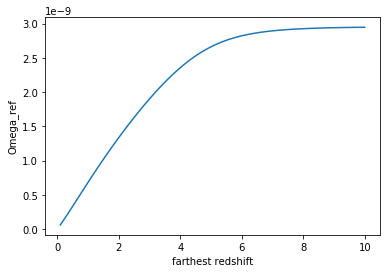

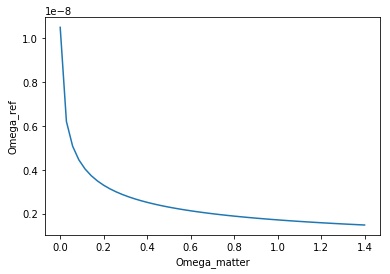

In [16]:
plt.plot(zf_array,Omega_gw_z_free)
#plt.axhline(OmegaGW_limit)
plt.xlabel('farthest redshift')
plt.ylabel('Omega_ref')
plt.show()

plt.plot(Omega_m_array,Omega_gw_Omegam_free)
#plt.axhline(OmegaGW_limit)
plt.xlabel('Omega_matter')
plt.ylabel('Omega_ref')
plt.show()